# Thermodynamics of learning by Entropic dynamics in Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import linalg as LA
from sklearn.datasets import make_spd_matrix

In [2]:
def F(u, noise= 0.1):
    const = (1-2*noise)/np.sqrt(2*np.pi)
    phi = norm.cdf(u)
    f = const*np.exp(-0.5*u*u) / (noise + (1- 2*noise)*phi)
    return f

def dF(u, noise= 0.1):

    df = -F(u, noise)*(u + F(u, noise))
    
    return df

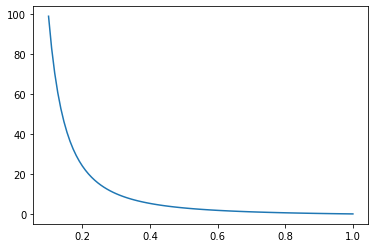

In [3]:
def gamma(rho):
    return (1 - rho*rho)/ (rho*rho)

pho = np.linspace(0.1, 1, 100)

plt.plot(pho, gamma(pho))
plt.show()

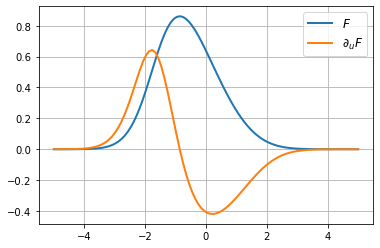

In [4]:
u = np.linspace(-5, 5, 100)
plt.plot(u, F(u), label= '$F$', linewidth= 2)
plt.plot(u, dF(u), label= '$\partial_{u} F$', linewidth= 2)
plt.legend(fontsize= 12)
plt.grid()
plt.show()

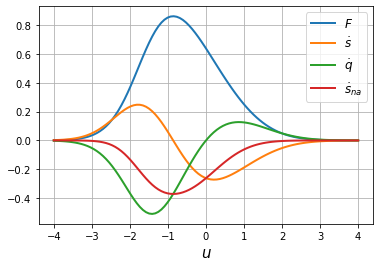

In [5]:
u = np.linspace(-4, 4, 100)
noise = 0.1


s = np.log(1 + dF(u, noise= noise))/2
q = -(dF(u, noise= noise) + F(u)*F(u))/2
s_na = s + q

plt.plot(u, F(u, noise= noise), label= '$F$', linewidth= 2, color= 'C0')
plt.plot(u, s, label= '$\dot{s}$', linewidth= 2, color= 'C1')
plt.plot(u, q, label= '$\dot{q}$', linewidth= 2, color= 'C2')
plt.plot(u, s_na, label= '$\dot{s}_{na}$', linewidth= 2, color= 'C3')
plt.xlabel('$u$', fontsize= 15)
plt.grid()
plt.legend(fontsize= 12)
plt.show()

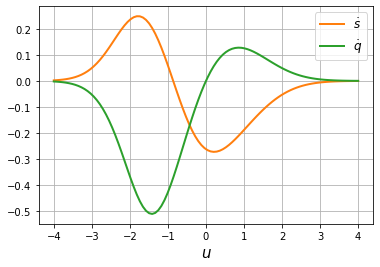

In [6]:
u = np.linspace(-4, 4, 100)
noise = 0.1


s = np.log(1 + dF(u, noise= noise))/2
q = -(dF(u, noise= noise) + F(u)*F(u))/2
s_na = s + q

#plt.plot(u, F(u, noise= noise), label= '$F$', linewidth= 2, color= 'C0')
plt.plot(u, s, label= '$\dot{s}$', linewidth= 2, color= 'C1')
plt.plot(u, q, label= '$\dot{q}$', linewidth= 2, color= 'C2')
#plt.plot(u, s_na, label= '$\dot{s}_{na}$', linewidth= 2, color= 'C3')
plt.xlabel('$u$', fontsize= 15)
plt.grid()
plt.legend(fontsize= 12)
plt.show()

## Entropic dynamics

In [9]:
N = 100
M = 600

### The teacher

In [10]:
w_B = np.ones(N)

In [11]:
x_train = np.random.randn(M, N)
y_train = np.array([np.sign(np.dot(x_train[j], w_B)) for j in range(M)])

Initialize weights

In [12]:
### Initialize

w = np.random.randn(N)             # Gaussian random weights
#C = np.random.rand(N, N)          # Uniform random correlations
#C = np.matmul(C, C.T)             # Make C0 symmetric, positive-definite 
#C = C / np.max(C)                 # Keep C0_{jk} small

# or sklearn option
C = make_spd_matrix(N, random_state= 12)


# Trace
traceC_ = []
# Delta S
S_ = []
# Delta q
q_ = []
# Overlap rho
rho_ = []
# C
C_ = []
# w
w_ = []

# Dynamics
for t in range(M):
    
    gamma = np.dot(x_train[t].T, np.matmul(C, x_train[t])) / N
    u = np.dot(w, x_train[t])*y_train[t] / np.sqrt(gamma*N)
    v = np.matmul(C, x_train[t])

    w_new = w + (1./np.sqrt(gamma*N)) * y_train[t]* F(u, noise= 0.1)*np.matmul(x_train[t], C)
    C_new = C + (1./(gamma*N)) * dF(u, noise= 0.1) * np.outer(v, v.T)


    # Monitor    
    traceC_.append(np.trace(C_new))
    S_.append(np.log(1+dF(u, noise= 0.1))/2)
    q_.append(-F(u, noise= 0.1)*F(u, noise= 0.1)/2  -dF(u, noise= 0.1)/2 )
    rho_.append(np.dot(w_new, w_B) / ( LA.norm(w_new)*LA.norm(w_B) ))
    C_.append(C_new)
    w_.append(w_new)


    # Recursive update
    w = w_new
    C = C_new

traceC_ = np.array(traceC_)
S_ = np.array(S_)
q_ = np.array(q_)
rho_ = np.array(rho_)
C_ = np.array(C_)
w_ = np.array(w_)

alpha = np.arange(M)/N

### Overlap $\rho$

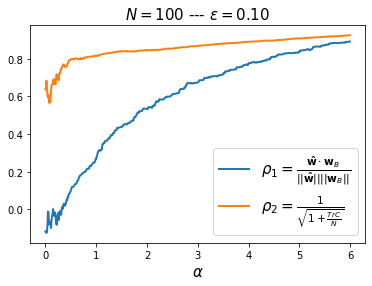

In [112]:
rho_C = 1 / np.sqrt( 1 + traceC_/N )

plt.plot(alpha, rho_, linewidth= 2, color= 'C0', label= r'$\rho_{1} = \frac{{\bf \hat{w}} \cdot {\bf w}_B}{ ||{\bf \hat{w}}|| ||{\bf w}_B ||}$')
plt.plot(alpha, rho_C, linewidth= 2, color= 'C1', label= r'$\rho_{2} = \frac{1}{\sqrt{1 + \frac{Tr C}{N}}}$' )
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.title('$N = %d$ --- $\epsilon = %.2f$' % (N, noise), fontsize= 15)
plt.legend(fontsize= 15)
#plt.savefig('rho.png', dpi= 600)
plt.show()

In [85]:
C_

array([[[ 1.66574453e+00,  1.39015360e+00, -5.71555427e-01, ...,
          9.99115938e-01, -1.24379419e+00,  1.56956955e-01],
        [ 1.39015360e+00,  2.24588499e+00, -6.56889202e-01, ...,
          1.20676323e+00, -1.57743524e+00,  1.98185525e-01],
        [-5.71555427e-01, -6.56889202e-01,  7.40649282e-01, ...,
         -4.56679754e-01,  5.98526293e-01, -9.12662292e-02],
        ...,
        [ 9.99115938e-01,  1.20676323e+00, -4.56679754e-01, ...,
          1.33320590e+00, -1.03834775e+00,  1.57280431e-01],
        [-1.24379419e+00, -1.57743524e+00,  5.98526293e-01, ...,
         -1.03834775e+00,  1.90111045e+00, -1.65519032e-01],
        [ 1.56956955e-01,  1.98185525e-01, -9.12662292e-02, ...,
          1.57280431e-01, -1.65519032e-01,  5.80804909e-01]],

       [[ 1.66472814e+00,  1.38808523e+00, -5.71271757e-01, ...,
          9.97745951e-01, -1.24053428e+00,  1.56702623e-01],
        [ 1.38808523e+00,  2.24167583e+00, -6.56311930e-01, ...,
          1.20397528e+00, -1.57080128e

In [86]:
w_

array([[-0.69501872, -0.50120591, -0.09192399, ..., -0.54580807,
        -0.31971944, -0.70436359],
       [-0.69915984, -0.50963315, -0.09076822, ..., -0.55138987,
        -0.30643746, -0.70539982],
       [-1.29914322, -1.22610161,  0.23836993, ..., -1.05658113,
         0.34635983, -0.80393767],
       ...,
       [ 0.50375195,  1.21395783,  1.35318317, ...,  1.40999358,
         0.59743237,  0.48011082],
       [ 0.49961077,  1.2121352 ,  1.35446436, ...,  1.40569919,
         0.60190302,  0.47491156],
       [ 0.45015032,  1.19537957,  1.38763301, ...,  1.44147341,
         0.59588722,  0.49279403]])

In [87]:
def integrand(x, g, w, C):

    J = w/N
    K = np.matmul(C, C)/N
    J_norm = LA.norm(J)

    Ig = np.exp(- g*x*x / 2*J_norm*J_norm) * dF(x, noise=0.1)*( np.trace(K) - np.dot(J.T, np.matmul(K, J)/J_norm*J_norm)*(1 - x*x*g/J_norm*J_norm))

    return Ig/ J_norm*np.sqrt(2*np.pi)

In [93]:
w = w_[100]

C = C_[100]

g = 1

from scipy.integrate import quad
I = quad(integrand, -np.inf, np.inf, args=(g, w, C))
print(I)

(-0.16163335343351165, 1.4601088112285296e-09)


In [107]:
from scipy.integrate import odeint

def dgdt(g, t, w_, C_):

    epsilon = 0.0001

    I = quad(integrand, -np.inf, np.inf, args=(g, w_, C_))

    dg_dt = I[0] / (g+epsilon)**(0.5)

    return dg_dt

In [102]:
g0 = 1
g = odeint(dgdt, g0, t, args= (w, C))

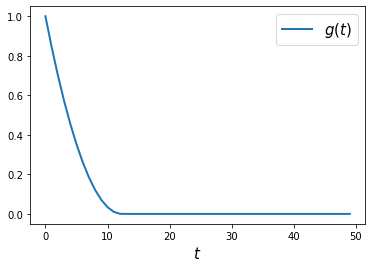

In [106]:
plt.plot(t[0:50], g[0:50], color= 'C0', linewidth=2, label = r'$g(t)$')
#plt.plot(t[0:50], 1/np.sqrt(1+ g), color= 'C1', linewidth=2, label = r'$ \frac{1}{\sqrt{1+g(t)}}$')
plt.legend(fontsize= 15)
plt.xlabel(r'$t$', fontsize= 15)
plt.show()

In [108]:
g0 = np.trace(C_[0]) / N
g_sol = []


for j in range(4):

    print('j =', j)


    dt = np.linspace(j, j+1, 10)

    #t = np.arange(M)


    g = odeint(dgdt, g0, dt, args= (w_[j], C_[j]))

    print(g)

    g0 = g[-1]

    print(g0)

    g_sol.append(g)

j = 0


KeyboardInterrupt: 

### $\text{Tr}\{{\cal C}\}/  N$ as function of $\alpha$

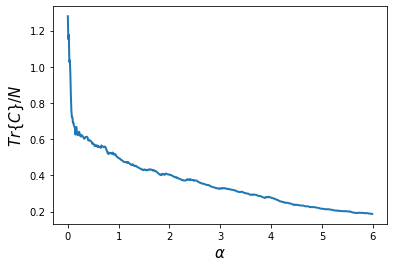

In [13]:
plt.plot(alpha, np.array(traceC_)/N, linewidth= 2)
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$ Tr\{ C \}/  N$', fontsize= 15)
plt.show()

In [14]:
def eg(x, a):
    return a*(1./x)

In [15]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(eg, alpha, 1-rho_)

In [16]:
popt

array([1.])

In [17]:
pcov

array([[inf]])

### Mutual Information

In [18]:
A_rho = np.arccos(rho) / np.pi
I = np.log(2) + A_rho*np.log(A_rho) + (1 - A_rho)*np.log(1-A_rho) 

rho = 1 / np.sqrt( 1 + traceC_/N )

#plt.plot(alpha, rho, linewidth= 2, label= r'$\rho$')
#plt.xlabel(r'$\alpha$', fontsize= 15)
#plt.ylabel(r'$\rho$', fontsize= 15)

plt.plot(alpha, I, linewidth= 2)
#plt.plot(alpha, rho, linewidth= 2, label= r'$\rho$')

#plt.xlabel(r'$\alpha$', fontsize= 15)
#plt.ylabel(r'$ Tr\{ C \}/  N$', fontsize= 15)

plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$I(\sigma_S; \sigma_T)$', fontsize= 15)
#plt.savefig('I.jpg')
plt.show()

NameError: name 'rho' is not defined

Entropy

In [ ]:
plt.plot(alpha[:100], S_[:100], linewidth= 2)
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$\dot s$', fontsize= 15)
plt.show()

In [ ]:
plt.plot(alpha[:100], q_[:100], linewidth= 2)
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$\dot q$', fontsize= 15)
plt.show()

In [ ]:
plt.plot(alpha[:100], (S_ + q_)[:100], linewidth= 2)
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'${\dot s}_{na}$', fontsize= 15)
plt.show()